# Sloan Digital Sky Survey Classification
### Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS

Source of Data: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

### Importing the necessary packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [2]:
data = pd.read_csv('/Users/kiarajacob/Downloads/star_classification.csv', skiprows=0)

## Exploratory Data Analysis

* OBJ_ID = Object Identifier
* alpha = J2000 Right Ascension (r-band)
* delta = J2000 Declination (r-band)

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

* run = Run Number
* rereun = Rerun Number
* camcol = Camera column
* field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:

- **run** number, which identifies the specific scan,
- the camera column, or "**camcol**," a number from 1 to 6, identifying the scanline within the run, and
- the **field** number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
- An additional number, **rerun**, specifies how the image was processed. 

* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)

The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

In [3]:
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [6]:
data['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

Here about 59% of the data is Galaxies while 21% is Stars and 18% is Quasars

## Data Cleaning

From the given dataset we can tell which features are unlikely to be related to the target variable 'class'.

**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.

Even more: The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

We will drop these columns as any correlation to the outcome would be coincidentally.

In [7]:
data.columns.values

array(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class',
       'redshift', 'plate', 'MJD', 'fiber_ID'], dtype=object)

In [8]:
data.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID'], axis=1, inplace=True)
data.head(1)

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.2753,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354,171


To start the analysis we will plot histograms for the 'redshift' feature column for each class. This will tell us how the redshift values are distributed over their range.

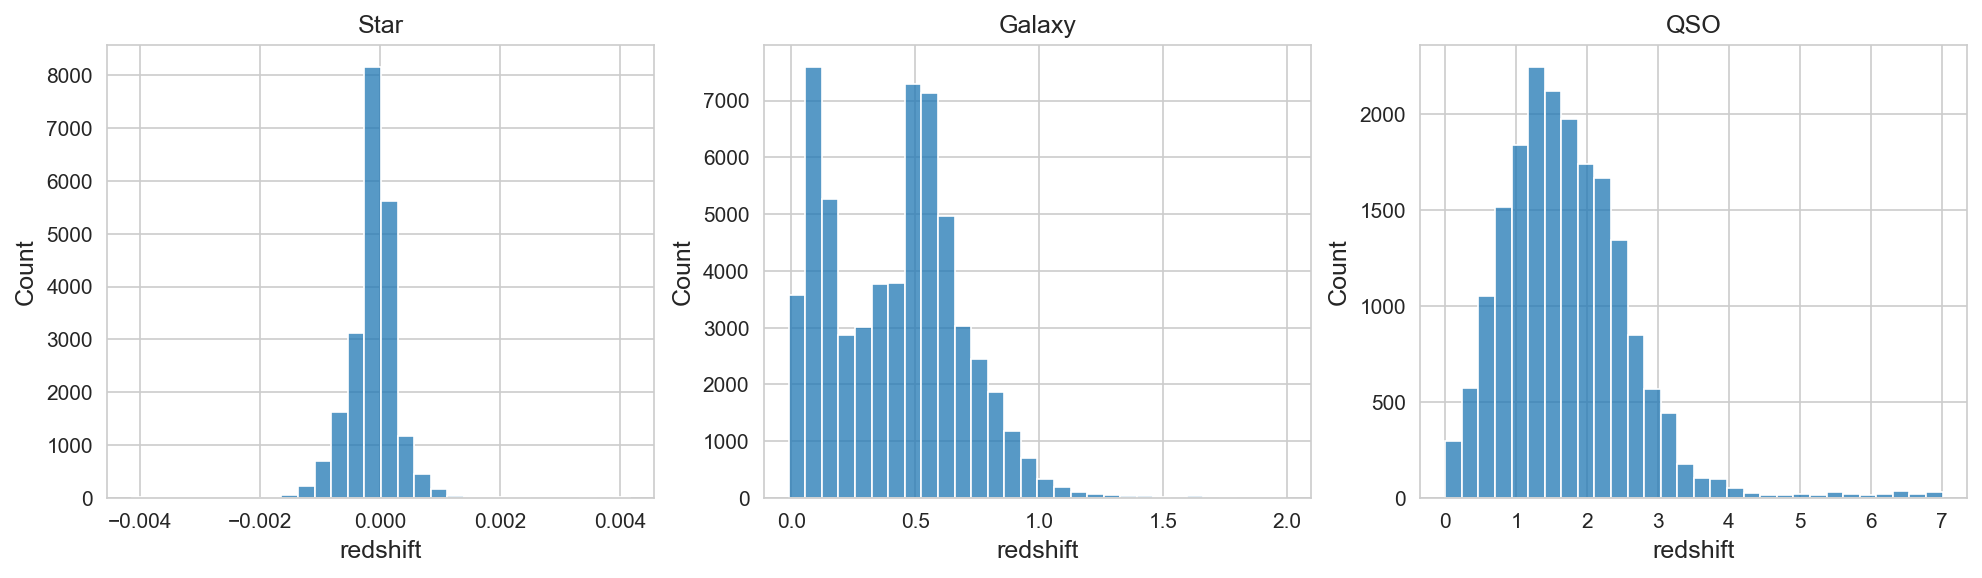

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.histplot(data[data['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.histplot(data[data['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.histplot(data[data['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

From the given graphs we can notice some interesting things:
* **Star:** The histogram looks like a truncated zero-centered normal distribution.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically.

**The redshift can be an estimate(!) for the distance from the earth to a object in space.**

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far. As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

Text(0.5, 1.0, 'delta')

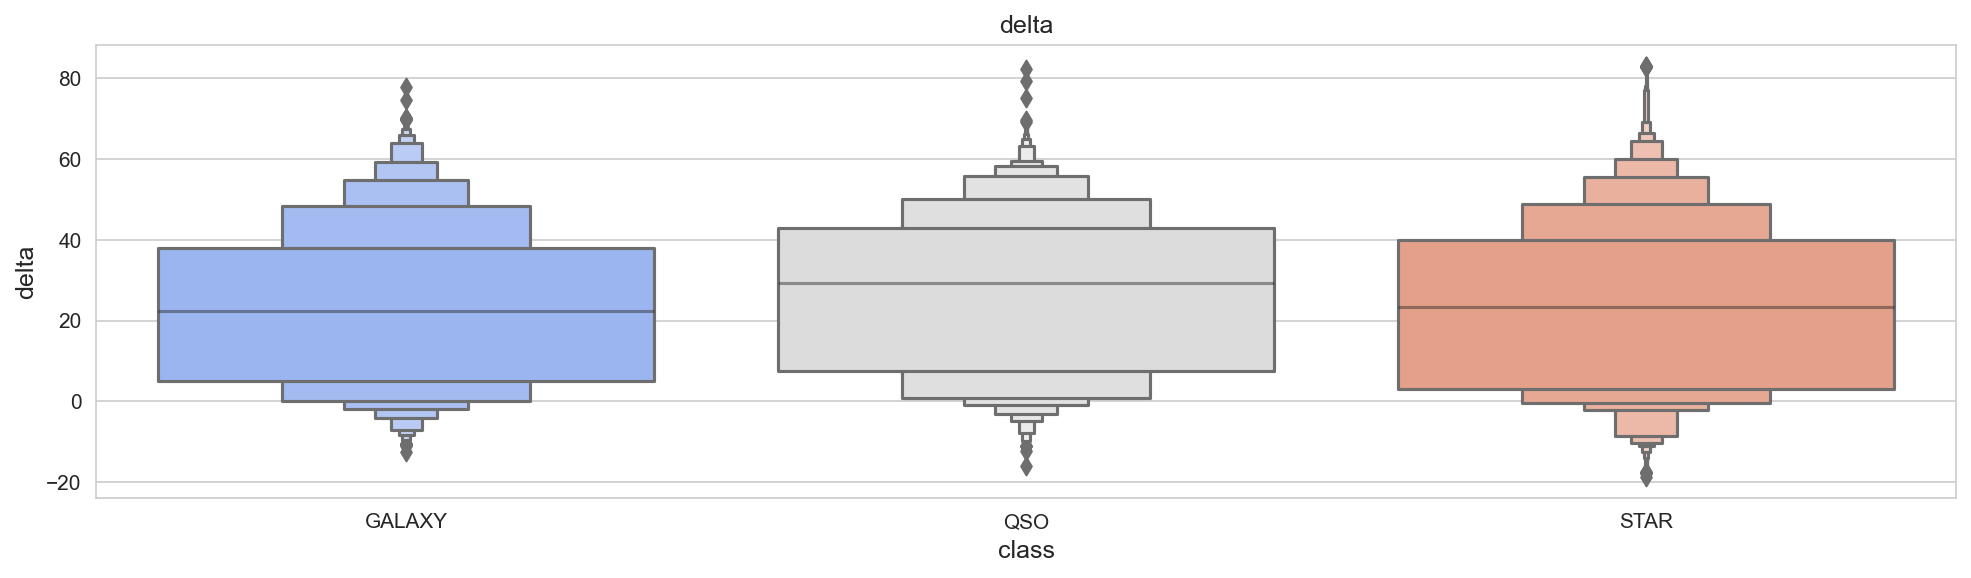

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=data['class'], y=data['delta'], palette='coolwarm')
ax.set_title('delta')

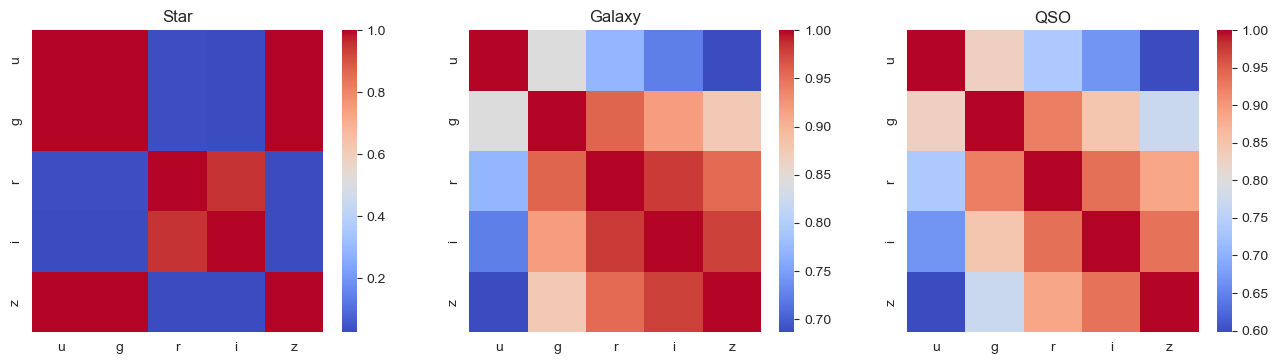

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(data[data['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(data[data['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(data[data['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

In [12]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo

radec = SkyCoord(ra=data['alpha']*u.degree, dec=data['delta']*u.degree, frame='icrs')
#radec.ra.value
#radec.dec.value
galactic = radec.galactic

data['l'] = galactic.l.value
data['b'] = galactic.b.value


r = cosmo.comoving_distance(data['redshift'])
data['distance']= r.value

data.head()

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD,fiber_ID,l,b,distance
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354,171,192.104251,40.686903,2348.607669
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158,427,195.346360,48.191106,2775.550683
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592,299,188.723749,46.390549,2377.525910
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039,775,66.431021,-47.730634,3191.016568
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187,842,91.215984,-34.805597,489.364023


In [13]:
def cartesian(dist,alpha,delta):
    x = dist*np.cos(np.deg2rad(delta))*np.cos(np.deg2rad(alpha))
    y = dist*np.cos(np.deg2rad(delta))*np.sin(np.deg2rad(alpha))
    z = dist*np.sin(np.deg2rad(delta))
    return x,y,z

cart = cartesian(data['distance'],data['alpha'],data['delta'])
data['x_coord'] = cart[0]
data['y_coord'] = cart[1]
data['z_coord'] = cart[2]

data.head()

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD,fiber_ID,l,b,distance,x_coord,y_coord,z_coord
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354,171,192.104251,40.686903,2348.607669,-1417.462576,1383.770025,1261.720390
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158,427,195.346360,48.191106,2775.550683,-1939.089177,1366.554469,1440.882938
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592,299,188.723749,46.390549,2377.525910,-1527.605588,1185.411154,1383.420044
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039,775,66.431021,-47.730634,3191.016568,2973.798109,-1156.982379,-22.434792
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187,842,91.215984,-34.805597,489.364023,441.324765,-115.922701,176.837569


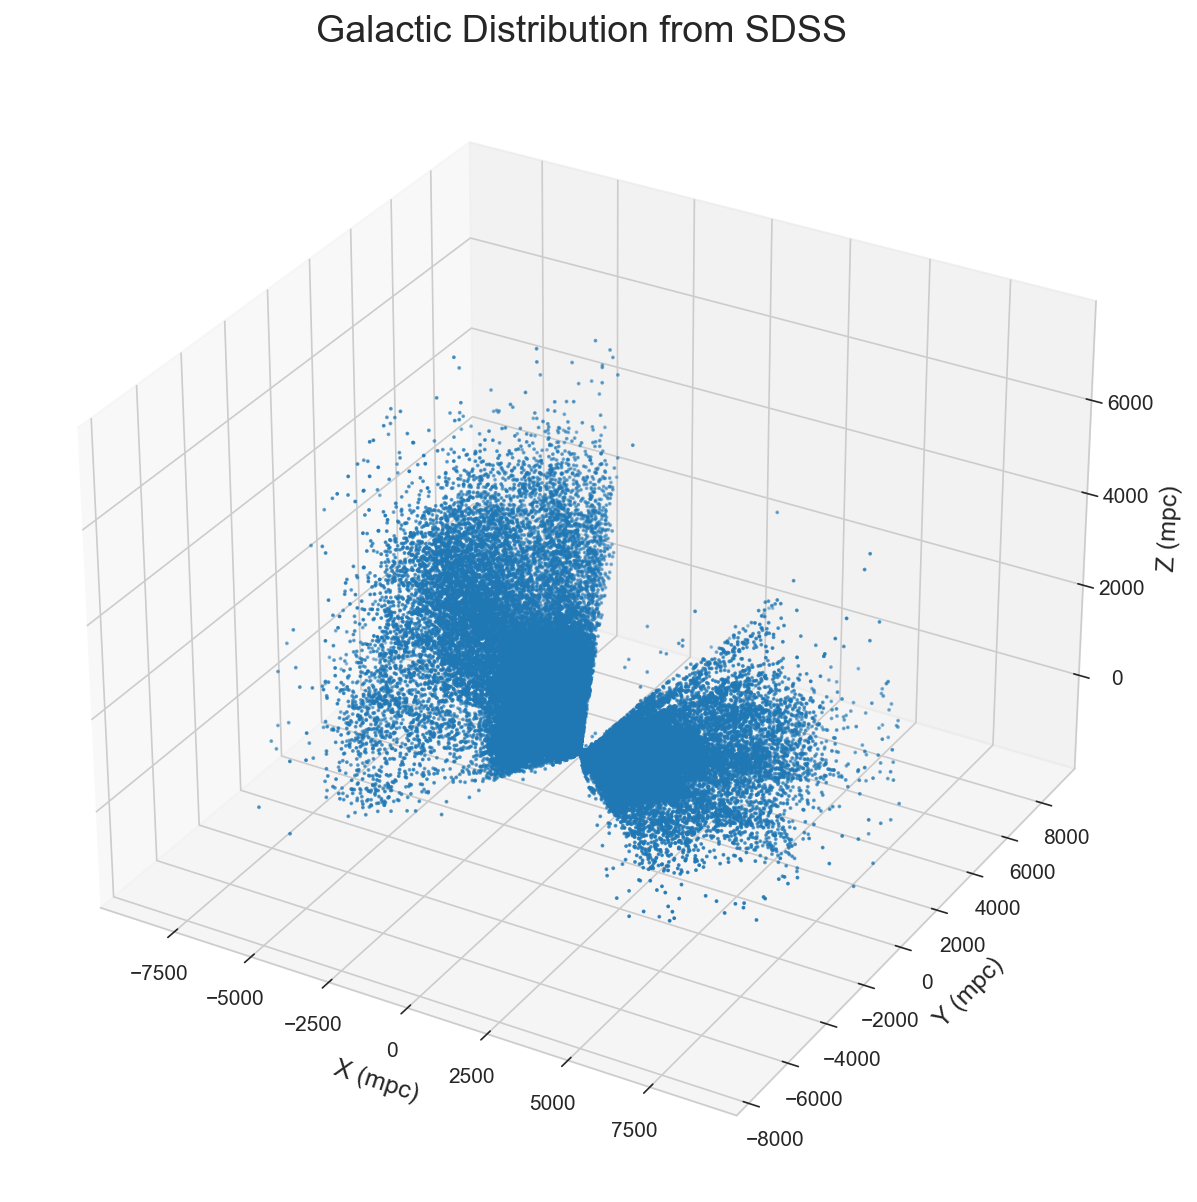

In [14]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['x_coord'],data['y_coord'],data['z_coord'], s = 0.7)
ax.set_xlabel('X (mpc)')
ax.set_ylabel('Y (mpc)')
ax.set_zlabel('Z (mpc)')
ax.set_title('Galactic Distribution from SDSS',fontsize=18)
plt.show()

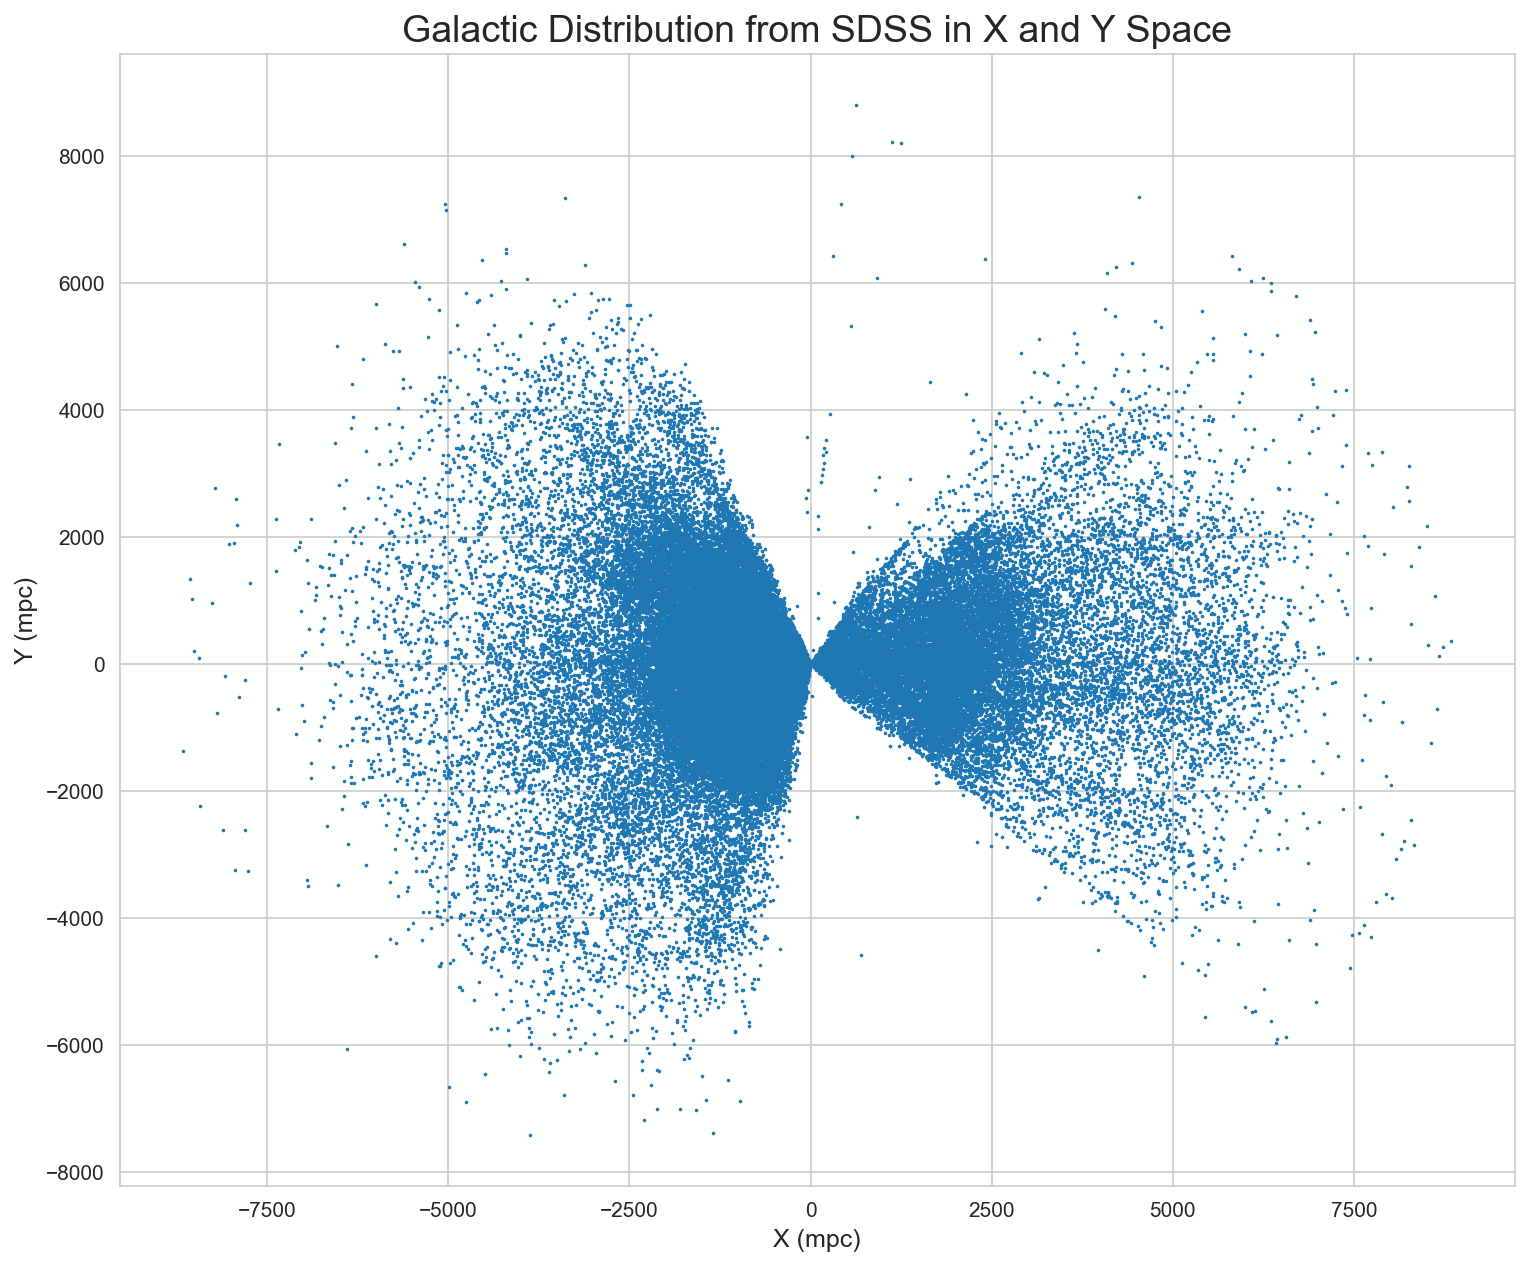

In [15]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(data['x_coord'],data['y_coord'], s = 0.5)
ax.set_xlabel('X (mpc)')
ax.set_ylabel('Y (mpc)')
ax.set_title('Galactic Distribution from SDSS in X and Y Space',fontsize=18)
plt.show()

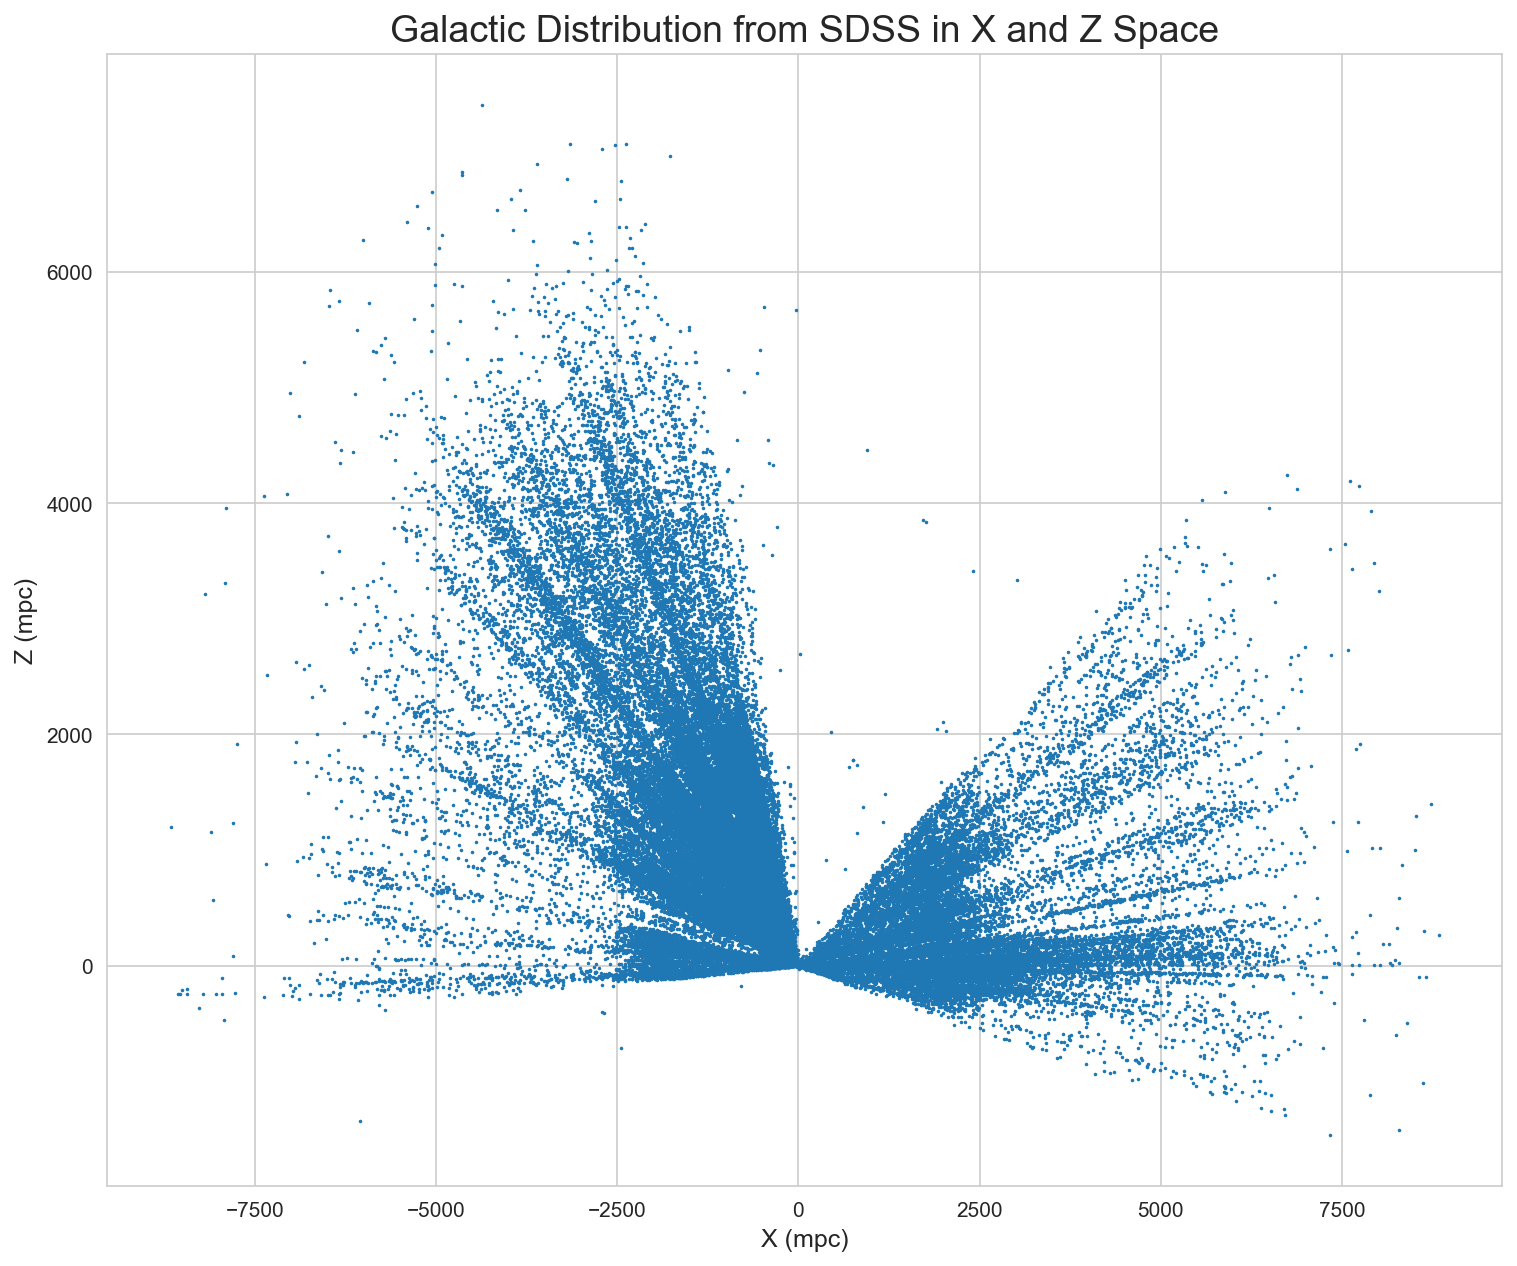

In [16]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(data['x_coord'],data['z_coord'], s = 0.5)
ax.set_xlabel('X (mpc)')
ax.set_ylabel('Z (mpc)')
ax.set_title('Galactic Distribution from SDSS in X and Z Space',fontsize=18)
plt.show()

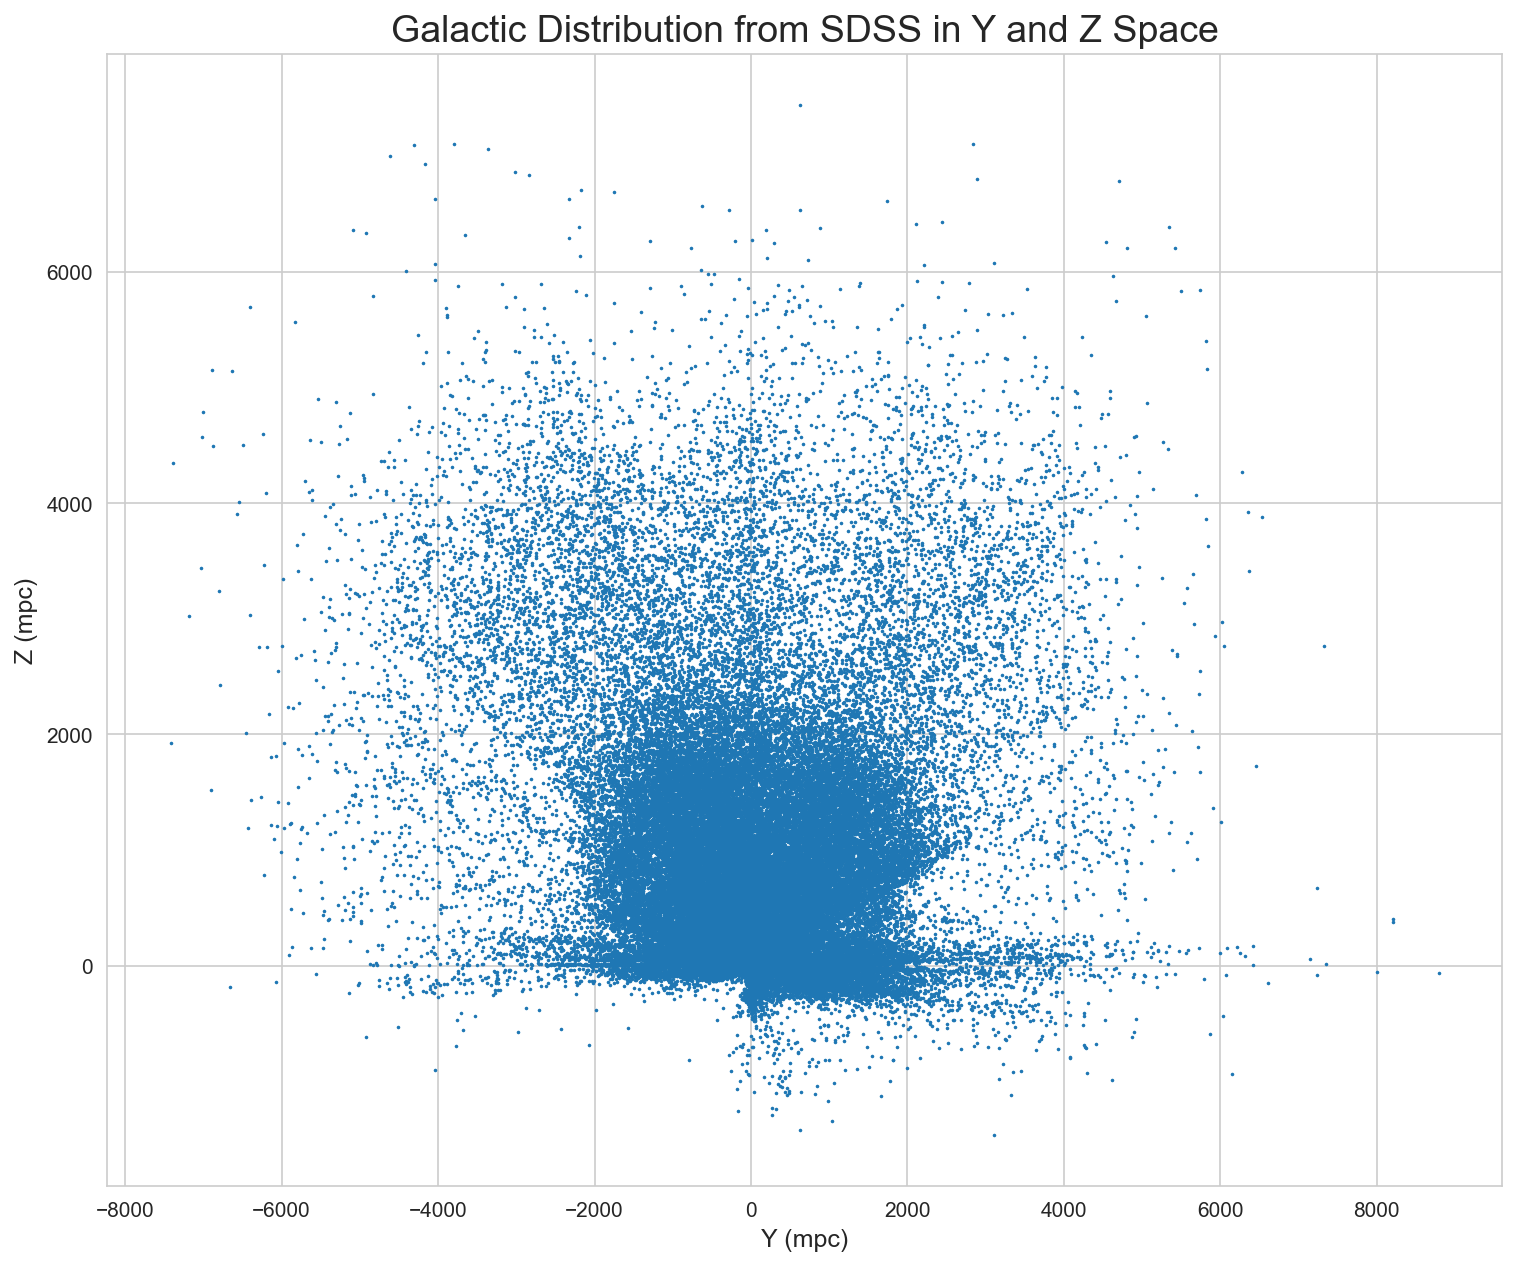

In [17]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(data['y_coord'],data['z_coord'], s = 0.5)
ax.set_xlabel('Y (mpc)')
ax.set_ylabel('Z (mpc)')
ax.set_title('Galactic Distribution from SDSS in Y and Z Space',fontsize=18)
plt.show()

<Figure size 1800x1500 with 0 Axes>

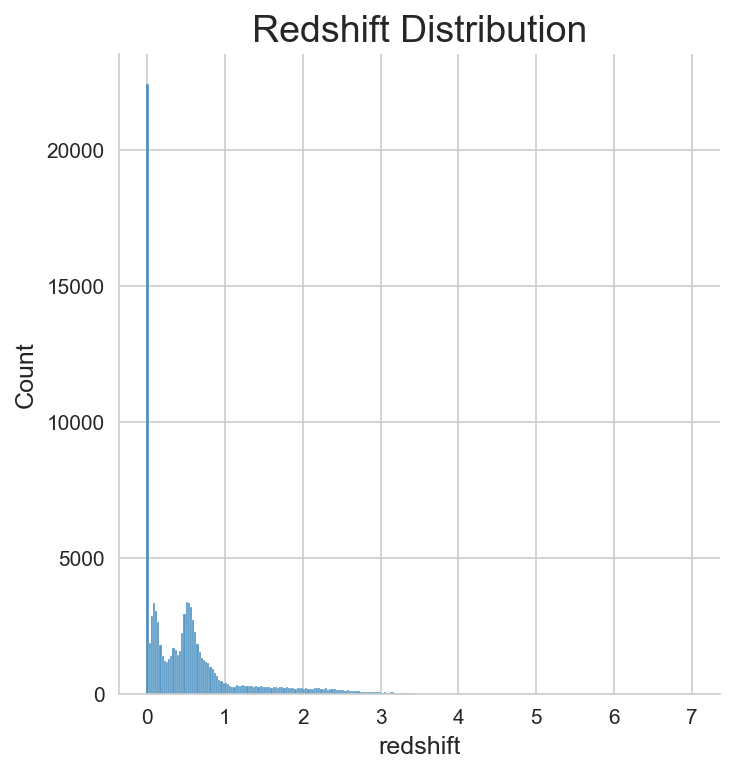

<Figure size 1800x1500 with 0 Axes>

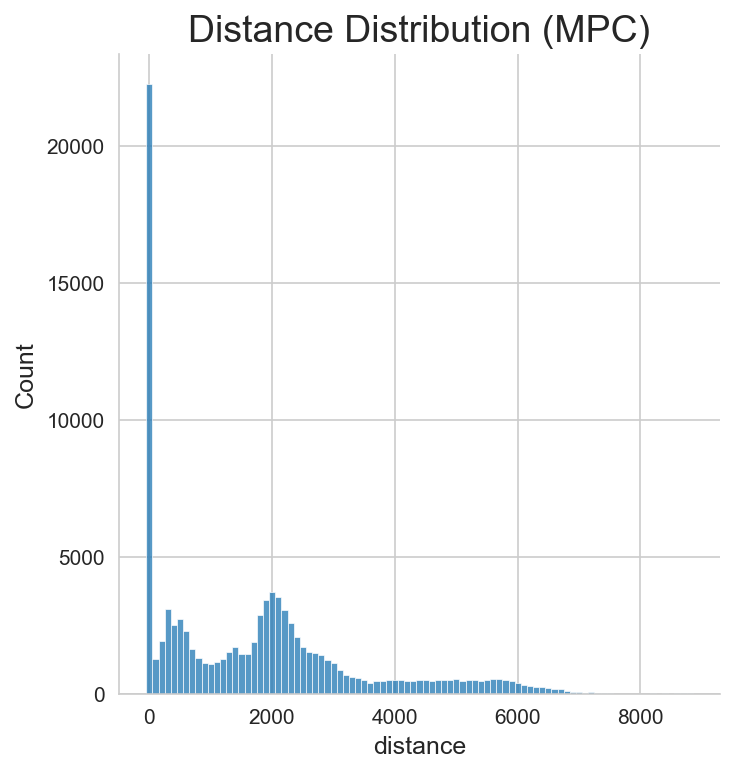

In [18]:
fig = plt.figure(figsize=(12,10))
sns.displot(data['redshift'])
plt.title('Redshift Distribution',fontsize=18)
plt.show()

fig = plt.figure(figsize=(12,10))
sns.displot(data['distance'])
plt.title('Distance Distribution (MPC)',fontsize=18)
plt.show()

## Feature Engineering

In [19]:
data_fe = data

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(data_fe['class'])
data_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(data_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
data_fe = pd.concat((data_fe, pd.DataFrame(ugriz)), axis=1)
data_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
data_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
data_fe.head()

,alpha,delta,class,redshift,plate,MJD,fiber_ID,l,b,distance,x_coord,y_coord,z_coord,PCA_1,PCA_2,PCA_3
0,135.689107,32.494632,0,0.634794,5812,56354,171,192.104251,40.686903,2348.607669,-1417.462576,1383.770025,1261.720390,-2.177351,0.564686,-1.383081
1,144.826101,31.274185,0,0.779136,10445,58158,427,195.346360,48.191106,2775.550683,-1939.089177,1366.554469,1440.882938,-4.652660,3.508729,-0.121728
2,142.188790,35.582444,0,0.644195,4576,55592,299,188.723749,46.390549,2377.525910,-1527.605588,1185.411154,1383.420044,-3.291268,0.769266,-2.227764
3,338.741038,-0.402828,0,0.932346,9149,58039,775,66.431021,-47.730634,3191.016568,2973.798109,-1156.982379,-22.434792,-2.305954,2.581008,-0.063649
4,345.282593,21.183866,0,0.116123,6121,56187,842,91.215984,-34.805597,489.364023,441.324765,-115.922701,176.837569,4.987014,-4.421144,-0.191848


## Feature Scaling

In [20]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(data_fe.drop('class', axis=1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sdss, data_fe['class'], test_size=0.33)

## Model Training
## K Nearest Neighbours

In [22]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 94.15
Time consumed for training: 0.091 seconds
Time consumed for prediction: 1.78395 seconds


## Naive Bayes

In [23]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(data_fe.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, data_fe['class'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 92.91
Time consumed for training: 0.020 seconds
Time consumed for prediction: 0.00920 seconds


## XGBoost

In [24]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 97.70
Time consumed for training: 11.027
Time consumed for prediction: 0.03594 seconds


## Random Forest Classifier

In [25]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 97.59
Time consumed for training: 2.021 seconds
Time consumed for prediction: 0.03934 seconds


## Support Vector Machine Classifier

In [26]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 96.11
Time consumed for training: 62.089 seconds
Time consumed for prediction: 46.05632 seconds


## Initial Results

In [27]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,97.696970,11.026571,0.035941
Random Forest,97.590909,2.020596,0.039338
SVC,96.106061,62.089232,46.056322
KNN,94.145455,0.091350,1.783950
Naive Bayes,92.906061,0.019818,0.009197


## K Fold Cross Validation

In [28]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.9780597  0.97522388 0.97940299 0.97865672 0.97791045 0.97492537
 0.97507463 0.97746269 0.97776119 0.98014925]
Mean: 0.9774626865671641
Standard Deviation: 0.001738021089911607


In [29]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.97835821 0.9758209  0.97791045 0.97955224 0.97701493 0.9738806
 0.97462687 0.97791045 0.97656716 0.97970149]
Mean: 0.9771343283582089
Standard Deviation: 0.0018459253532824335


## Checking Feature Importance with Decision Trees

In [30]:
importances = pd.DataFrame({
    'Feature': data_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.825548
PCA_3,0.043563
PCA_1,0.032493
z_coord,0.017754
plate,0.016974
MJD,0.010842
PCA_2,0.010820
y_coord,0.006717
l,0.006571


<AxesSubplot:xlabel='Feature'>

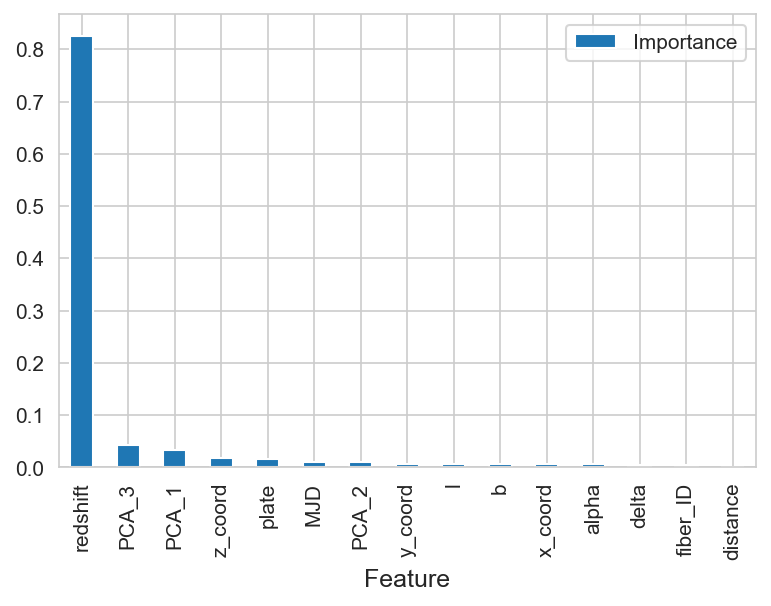

In [31]:
importances.plot.bar()

In [32]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(data_fe.drop(['MJD', 'class'], axis=1)), columns=data_fe.drop(['MJD', 'class'], axis=1).columns)
sdss['class'] = data_fe['class']

In [33]:
sdss.head()

,alpha,delta,redshift,plate,fiber_ID,l,b,distance,x_coord,y_coord,z_coord,PCA_1,PCA_2,PCA_3,class
0,0.376905,0.503802,0.091831,0.451592,0.170170,0.533619,0.715486,0.268879,0.413880,0.542773,0.305837,0.000440,0.256336,0.398815,0
1,0.402286,0.491812,0.112389,0.828841,0.426426,0.542625,0.759618,0.316875,0.384075,0.541711,0.325958,0.000297,0.308956,0.459283,0
2,0.394960,0.534139,0.093170,0.350949,0.298298,0.524229,0.749029,0.272130,0.407586,0.530540,0.319504,0.000375,0.259992,0.358322,0
3,0.940947,0.180600,0.134210,0.723312,0.774775,0.184519,0.195500,0.363580,0.664785,0.386073,0.161622,0.000432,0.292375,0.462067,0
4,0.959118,0.392679,0.017959,0.476753,0.841842,0.253368,0.271513,0.059870,0.520086,0.450280,0.184001,0.000852,0.167221,0.455922,0


## Finding the best hyperparameters

In [34]:
sdss.to_csv('sdss_data.csv')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sdss.drop('class', axis=1), sdss['class'],
                                                   test_size=0.33)

In [36]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 97.57


In [37]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.97268657 0.97701493 0.97746269 0.97567164 0.97432836 0.97626866
 0.97925373 0.97507463 0.97776119 0.97567164]
Mean: 0.9761194029850747
Standard Deviation: 0.0017785634757929657


## Model Evaluation

In [38]:
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

{0: 59445, 1: 18961, 2: 21594}

In [39]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
cm = confusion_matrix(sdss['class'], predictions)
df = pd.DataFrame(cm, columns = ["Galaxy", 'Quasar', 'Star'])
df

,Galaxy,Quasar,Star
0,58629,725,91
1,1471,17487,3
2,9,0,21585
